####F. Build a k-Nearest Neighbors Model

* The k-nearest neighbors (KNN) model cannot be trained upon the IBM employee churn modeling data since the MLlib library does not include KNN among its machine learning algorithms.

####G. Build a Decision Tree Model

**Initiate new Spark session.**

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Employee_Attrition_Part_3').getOrCreate()

**Import numpy, pandas, and data visualization libraries.**

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Import churn modeling CSV file into PySpark dataframe called churn_model2.**

In [9]:
churn_model2 = spark.read.csv('/FileStore/tables/churn_modeling_data.csv', inferSchema=True, header=True)

**Check number of rows and columns in churn_model2 dataframe.**

In [11]:
print(churn_model2.count(), len(churn_model2.columns))

1470 11

**View structure of churn_model2 dataframe.**

In [13]:
churn_model2.printSchema()

root
-- Churn: integer (nullable = true)
-- Age: integer (nullable = true)
-- DistanceFromHome: integer (nullable = true)
-- EnvironmentSatisfaction: integer (nullable = true)
-- JobInvolvement: integer (nullable = true)
-- MonthlyIncome: integer (nullable = true)
-- StockOptionLevel: integer (nullable = true)
-- Sales_Rep: integer (nullable = true)
-- Single: integer (nullable = true)
-- BusTravLevel: integer (nullable = true)
-- Overtime_Dum: integer (nullable = true)

**View first five rows of churn_model2 dataframe.**

In [15]:
display(churn_model2.head(5))

Churn,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
1,41,1,1,2,5993,0,0,1,1,1
0,49,8,2,1,5130,1,0,0,2,0
1,37,2,3,1,2090,0,0,1,1,1
0,33,3,3,2,2909,0,0,0,2,1
0,27,2,0,2,3468,1,0,0,1,0


**Convert predictor features into vector column using VectorAssembler.**

In [17]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [18]:
assembler = VectorAssembler(inputCols=['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome', 'StockOptionLevel', 'Sales_Rep', 'Single', 'BusTravLevel', 'Overtime_Dum'], outputCol='features')

In [19]:
churn_model2_vect = assembler.transform(churn_model2)
display(churn_model2_vect.head(5))

Churn,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum,features
1,41,1,1,2,5993,0,0,1,1,1,"List(1, 10, List(), List(41.0, 1.0, 1.0, 2.0, 5993.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
0,49,8,2,1,5130,1,0,0,2,0,"List(1, 10, List(), List(49.0, 8.0, 2.0, 1.0, 5130.0, 1.0, 0.0, 0.0, 2.0, 0.0))"
1,37,2,3,1,2090,0,0,1,1,1,"List(1, 10, List(), List(37.0, 2.0, 3.0, 1.0, 2090.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
0,33,3,3,2,2909,0,0,0,2,1,"List(1, 10, List(), List(33.0, 3.0, 3.0, 2.0, 2909.0, 0.0, 0.0, 0.0, 2.0, 1.0))"
0,27,2,0,2,3468,1,0,0,1,0,"List(1, 10, List(), List(27.0, 2.0, 0.0, 2.0, 3468.0, 1.0, 0.0, 0.0, 1.0, 0.0))"


**Tune decision tree model to avoid overfitting.**

In [21]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [22]:
train_model_data, test_model_data = churn_model2_vect.randomSplit([0.7, 0.3], seed=100)
acc_eval = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol='prediction', metricName='accuracy')

In [23]:
max_depth_range1 = range(1, 11)

acc_scores1 = []

for depth in max_depth_range1:
  dtc1 = DecisionTreeClassifier(labelCol='Churn', featuresCol='features', maxDepth=depth)
  dtc1_model = dtc1.fit(train_model_data)
  dtc1_predictions = dtc1_model.transform(test_model_data)
  acc_scores1.append(acc_eval.evaluate(dtc1_predictions))

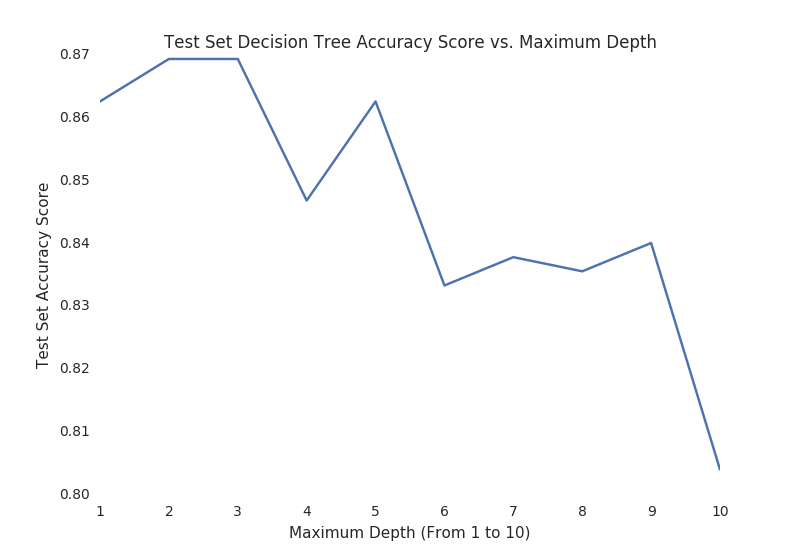

In [24]:
dtc_max_depth, ax = plt.subplots()
ax.plot(max_depth_range1, acc_scores1)
ax.set_xlabel('Maximum Depth (From 1 to 10)')
ax.set_ylabel('Test Set Accuracy Score')
ax.set_title('Test Set Decision Tree Accuracy Score vs. Maximum Depth')
display(dtc_max_depth)

In [25]:
dict(zip(max_depth_range1, acc_scores1))

Out[ 14 ]: 
{1: 0.8626126126126126,
 2: 0.8693693693693694,
 3: 0.8693693693693694,
 4: 0.8468468468468469,
 5: 0.8626126126126126,
 6: 0.8333333333333334,
 7: 0.8378378378378378,
 8: 0.8355855855855856,
 9: 0.8400900900900901,
 10: 0.8040540540540541}

* The maximum depth of the decision tree should be 2 since the tree has a maximum test set accuracy score of 0.873.

**Decide which random state seed number will produce the highest accuracy score for a decision tree with a maximum depth of 2.**

In [28]:
dtc2 = DecisionTreeClassifier(labelCol='Churn', featuresCol='features', maxDepth=2)

In [29]:
number_range2 = range(120, 126)

acc_scores2 = []

for number in number_range2:
  train_model_data, test_model_data = churn_model2_vect.randomSplit([0.7, 0.3], seed=number)
  dtc2_model = dtc2.fit(train_model_data)
  dtc2_predictions = dtc2_model.transform(test_model_data)
  acc_scores2.append(acc_eval.evaluate(dtc2_predictions))

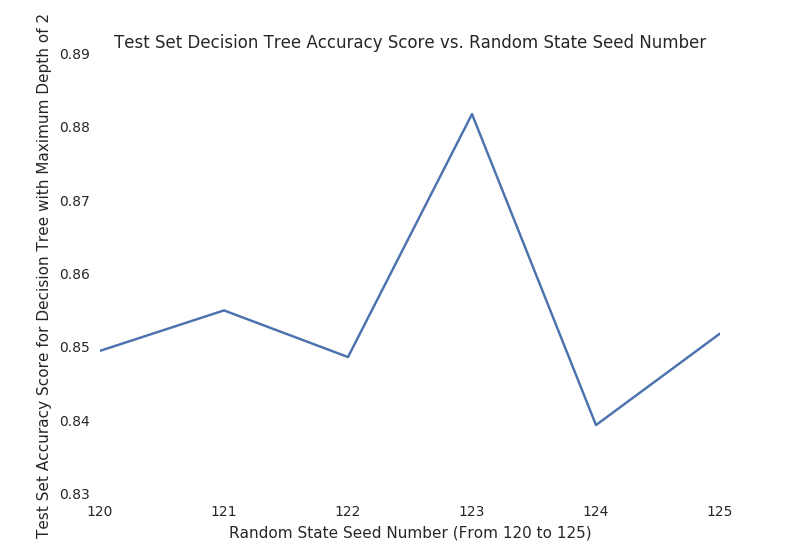

In [30]:
dtc_acc_seed, ax = plt.subplots()
ax.plot(number_range2, acc_scores2)
ax.set_xlabel('Random State Seed Number (From 120 to 125)')
ax.set_ylabel('Test Set Accuracy Score for Decision Tree with Maximum Depth of 2')
ax.set_title('Test Set Decision Tree Accuracy Score vs. Random State Seed Number')
display(dtc_acc_seed)

In [31]:
dict(zip(number_range2, acc_scores2))

Out[ 18 ]: 
{120: 0.8496583143507973,
 121: 0.8551724137931035,
 122: 0.8488120950323974,
 123: 0.8819444444444444,
 124: 0.8395348837209302,
 125: 0.852017937219731}

* 123 is the random state seed number that will produce the highest test set accuracy score for the decision tree with a maximum depth of 2.

**Split churn / attrition modeling data into training and test sets.**

In [34]:
train_model_data, test_model_data = churn_model2_vect.randomSplit([0.7, 0.3], seed=123)

In [35]:
print(churn_model2_vect.count(), len(churn_model2_vect.columns))
print(train_model_data.count(), len(train_model_data.columns))
print(test_model_data.count(), len(test_model_data.columns))

1470 12
1038 12
432 12

**Fit a decision tree with a maximum depth of 2 on training data set.**

In [37]:
dtc3_model = dtc2.fit(train_model_data)

**Make predictions on test data set and calculate accuracy score.**

In [39]:
dtc3_predictions = dtc3_model.transform(test_model_data)
print('Test Set Accuracy Score for Decision Tree with Maximum Depth of 2: ', acc_eval.evaluate(dtc3_predictions))

Test Set Accuracy Score for Decision Tree with Maximum Depth of 2: 0.8819444444444444

**Compute test set null accuracy score manually.**

In [41]:
from pyspark.sql.functions import col, avg
dtc3_predictions.agg(1 - avg(col('Churn'))).show()

+------------------+
 (1 - avg(Churn))|
+------------------+
0.8611111111111112|
+------------------+

**Display decision tree produced using training set.**

In [43]:
display(dtc3_model)

treeNode
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":0.5,""categories"":null,""feature"":9,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":2541.5,""categories"":null,""feature"":4,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"


**List out decision tree predictor features and their respective importances.**

In [45]:
feature_cols = ['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome', 'StockOptionLevel', 'Sales_Rep', 'Single', 'BusTravLevel', 'Overtime_Dum']
dict(zip(feature_cols, dtc3_model.featureImportances))

Out[ 25 ]: 
{'JobInvolvement': 0.0,
 'BusTravLevel': 0.0,
 'Age': 0.0,
 'MonthlyIncome': 0.43013338886268188,
 'EnvironmentSatisfaction': 0.0,
 'Overtime_Dum': 0.56986661113731818,
 'DistanceFromHome': 0.0,
 'StockOptionLevel': 0.0,
 'Sales_Rep': 0.0,
 'Single': 0.0}

**Calculate number of true negatives, false positives, false negatives, and true positives in test data set, which is all four figures that comprise a confusion matrix.**

In [47]:
print('True Negatives: ', dtc3_predictions.filter((dtc3_predictions['Churn'] == 0) & (dtc3_predictions['prediction'] == 0)).count())
print('False Positives: ', dtc3_predictions.filter(dtc3_predictions['Churn'] < dtc3_predictions['prediction']).count())
print('False Negatives: ', dtc3_predictions.filter(dtc3_predictions['Churn'] > dtc3_predictions['prediction']).count())
print('True Positives: ', dtc3_predictions.filter((dtc3_predictions['Churn'] == 1) & (dtc3_predictions['prediction'] == 1)).count())

True Negatives: 366
False Positives: 6
False Negatives: 45
True Positives: 15

**Manually calculate accuracy score and misclassification / error rate, precision, recall / sensitivity, and specificity.**

In [49]:
print('Accuracy Score: ', float(366 + 15) / float(366 + 6 + 45 + 15))
print('Misclassification / Error Rate: ', float(6 + 45) / float(366 + 6 + 45 + 15))
print('Precision: ', float(15) / float(6 + 15))
print('Recall / Sensitivity: ', float(15) / float(45 + 15))
print('Specificity: ', float(366) / float(366 + 6))

Accuracy Score: 0.8819444444444444
Misclassification / Error Rate: 0.11805555555555555
Precision: 0.7142857142857143
Recall / Sensitivity: 0.25
Specificity: 0.9838709677419355

* Precision measures how confident the training set decision tree model captures the positives. Recall / sensitivity measures how well the training set decision tree model captures the positives. Specificity measures how well the training set decision tree model captures the negatives.

**List out false positives in test data set.**

In [52]:
targ_feat_cols = ['Churn', 'prediction', 'Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome', 'StockOptionLevel', 'Sales_Rep', 'Single', 'BusTravLevel', 'Overtime_Dum']
display(dtc3_predictions.filter(dtc3_predictions['Churn'] < dtc3_predictions['prediction']).select(targ_feat_cols))

Churn,prediction,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
0,1.0,27,5,2,2,2478,0,0,1,1,1
0,1.0,27,5,3,2,2379,0,0,1,2,1
0,1.0,31,11,3,2,2356,1,0,0,1,1
0,1.0,38,2,3,2,1702,1,0,0,2,1
0,1.0,38,8,3,1,2133,1,0,0,2,1
0,1.0,44,1,1,2,2436,0,0,1,1,1


**List out false negatives in test data set.**

In [54]:
display(dtc3_predictions.filter(dtc3_predictions['Churn'] > dtc3_predictions['prediction']).select(targ_feat_cols))

Churn,prediction,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
1,0.0,19,1,2,0,2325,0,1,1,2,0
1,0.0,20,4,0,2,2973,0,0,1,1,0
1,0.0,21,7,1,2,2679,0,1,1,1,0
1,0.0,21,10,2,1,1416,0,0,1,1,0
1,0.0,24,22,3,0,1555,1,0,0,1,0
1,0.0,25,3,0,2,4031,1,0,0,1,0
1,0.0,26,17,1,2,2741,1,0,0,2,1
1,0.0,26,21,0,2,2377,1,0,0,1,0
1,0.0,26,25,0,0,2293,0,0,1,1,0
1,0.0,26,29,1,0,4969,0,0,1,0,0


**Generate training set decision tree models using 10-fold cross-validation.**

In [56]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [57]:
paramGrid = (ParamGridBuilder().addGrid(dtc2.maxDepth, [1, 2, 6, 10]).addGrid(dtc2.maxBins, [20, 40, 80]).build())
cv = CrossValidator(estimator=dtc2, estimatorParamMaps=paramGrid, evaluator=acc_eval, numFolds=10)
cv_dtc_model = dtc2.fit(train_model_data)

**Compute training set number of nodes and maximum tree depth, and test set accuracy score for best cross-validation model.**

In [59]:
print('Best Cross-Validation Training Set Decision Tree Model Metrics')
print('Number of Nodes: ', cv_dtc_model.numNodes)
print('Maximum Depth: ', cv_dtc_model.depth)

Best Cross-Validation Training Set Decision Tree Model Metrics
Number of Nodes: 5
Maximum Depth: 2

In [60]:
cv_dtc_predictions = cv_dtc_model.transform(test_model_data)
print('Best Cross-Validation Test Set Decision Tree Model Metrics')
print('Test Set Accuracy Score: ', acc_eval.evaluate(cv_dtc_predictions))

Best Cross-Validation Test Set Decision Tree Model Metrics
Test Set Accuracy Score: 0.8819444444444444